Pipe, validação e treinamento

In [47]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, when
from pyspark.ml import Pipeline

import mlflow
import mlflow.spark
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import col, when

import matplotlib.pyplot as plt

import os

Carregar dados limpos

In [48]:
spark = SparkSession.builder \
    .appName("ValidacaoDeDadosLimpos") \
    .getOrCreate()

# Leia os dados Parquet de volta para um DataFrame Spark
df = spark.read.parquet('../dataset/churn-bigml-80_limpo')
df.cache()

display(df.head())
df.show(5)

Row(State='KS', Account length=128, Area code=415, International plan='No', Voice mail plan='Yes', Number vmail messages=25, Total day minutes=265.1, Total day calls=110, Total day charge=45.07, Total eve minutes=197.4, Total eve calls=99, Total eve charge=16.78, Total night minutes=244.7, Total night calls=91, Total night charge=11.01, Total intl minutes=10.0, Total intl calls=3, Total intl charge=2.7, Customer service calls=1, Churn=False)

+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|State|Account length|Area code|International plan|Voice mail plan|Number vmail messages|Total day minutes|Total day calls|Total day charge|Total eve minutes|Total eve calls|Total eve charge|Total night minutes|Total night calls|Total night charge|Total intl minutes|Total intl calls|Total intl charge|Customer service calls|Churn|
+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|   

Validações

In [49]:
# 1. Contar o número de nulos na coluna 'Churn'
num_nulos_churn = df.filter(col("Churn").isNull()).count()

# 2. Usar o assert para verificar se a contagem de nulos é zero
assert num_nulos_churn == 0, "Coluna 'Churn' possui valores nulos!"

print("Validação de dados concluída com sucesso")

Validação de dados concluída com sucesso


Convert categorical fields into numeric fields.

In [50]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

#labelIndexer = StringIndexer(inputCol = 'Churn', outputCol = 'label')
ipIndexer = StringIndexer(inputCol = 'International plan', outputCol = 'ipIndex')
ipEncoder = OneHotEncoder(inputCol = 'ipIndex', outputCol = 'ipVector')

Define feature fields. We choose to ignore some fields as we think they are not relevant.

In [51]:
from pyspark.ml.feature import VectorAssembler

featureCols = ['Account length', 'ipVector', 'Number vmail messages', 'Total day minutes',
     'Total day calls', 'Total eve minutes', 'Total eve calls', 'Total night minutes', 'Total night calls', 
     'Total intl minutes', 'Total intl calls', 'Customer service calls']
assembler = VectorAssembler(inputCols = featureCols, outputCol = 'features')

Create a logistic transformer.

In [52]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter = 20)

Create numeric label field.

In [53]:
df = df.withColumn('Churn', when(col('Churn') == True, 'Yes')
                               .when(col('Churn') == False, 'No')
                               .otherwise(col('Churn').cast('string'))) # Trata outros casos, se houver
indexer = StringIndexer(inputCol='Churn', outputCol='label')
df.printSchema()
df = df.drop('label')
df = indexer.fit(df).transform(df)

# Opcional: Persiste o DataFrame em cache para otimização
df.cache()

# Verificação: exibe o esquema e as primeiras linhas com a nova coluna 'label'
df.printSchema()
df.select('Churn', 'label').show(5)



root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: string (nullable = true)

root
 |-- State: string (nullable = 

Chain all transformers and train the model.

In [54]:
pipeline = Pipeline(stages=[ipIndexer, ipEncoder, assembler, lr])
model = pipeline.fit(df)

Display auROC of the trained model.

In [55]:
lrModel = model.stages[-1]
trainingSummary = lrModel.summary
print ('Train auROC = %3.2f' % trainingSummary.areaUnderROC)

Train auROC = 0.82


Plot ROC Curve.

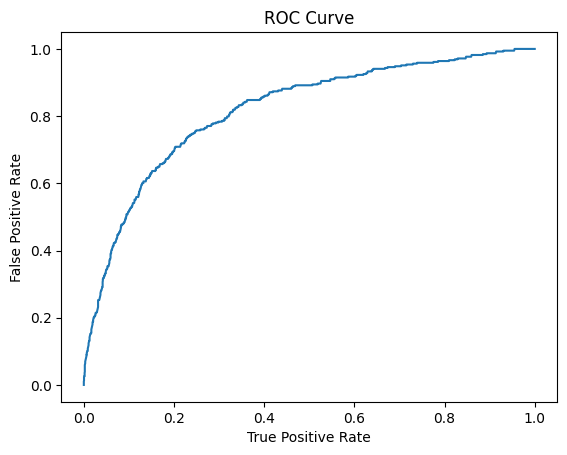

In [56]:
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Salvar o modelo e usar MLFLOW

In [ ]:
mlflow_base_dir = os.path.join(os.getcwd(), 'mlf_data') 
os.makedirs(mlflow_base_dir, exist_ok=True) 

# Define o URI de rastreamento para uma pasta local
tracking_uri = f"sqlite:///{mlflow_base_dir}/mlflow.db" 
artifact_location = f"file:///{mlflow_base_dir}/mlruns"
mlflow.set_tracking_uri(tracking_uri)

mlflow.set_experiment("churn_prediction")

with mlflow.start_run() as run:
    mlflow.log_param("modelo", "LogisticRegression")
    mlflow.log_param("vetor", "StringIndexer_OneHotEncoder_VectorAssembler")

    mlflow.spark.log_model(
        spark_model=model,
        artifact_path="churn_model",
        registered_model_name="ChurnPrediction"
    )

(mlflow_base_dir c:\MONICA\Estudos\MBA-Ufscar2025\ESBD3\Projeto2\notebooks\mlf_data)


2025/07/14 16:53:46 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\mosme\AppData\Local\Temp\tmp59d6hnz0\model, flavor: spark). Fall back to return ['pyspark==4.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/07/14 16:53:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'ChurnPrediction' already exists. Creating a new version of this model...
Created version '3' of model 'ChurnPrediction'.
